### Make sure to use uncertainties package 2.4.8.1, not 3.0.1.  Otherwise cell 9 will fail.
To get the older version run

pip install uncertainties==2.4.8.1

If you already have the new version, first run

pip uninstall uncertainties

In [1]:
# Setup for handling notebook/script python interpreter mode
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

# User Booleans for controling output
    
makebokeh = False

In [2]:
import time
import sys
import pickle
import os
import json
import numpy as np
if 'matplotlib.pyplot' not in sys.modules:
    import matplotlib as mpl
    mpl.use('Agg')
    import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.constants as scc
import scipy.integrate as scint
import scipy.special as scsp
import scipy.io as scio
import scipy.interpolate as sctrp
import scipy.signal
import uncertainties as unc
from uncertainties import ufloat as uf
from uncertainties import unumpy as unp
from IPython.display import clear_output


if isnotebook():
    %matplotlib inline

mpl.rcParams.update({'text.usetex': True,
                     'text.color':'k',
                     'lines.linewidth': 4,
                     'lines.markersize': 12,
                     'font.size': 34, 
                     'font.family': 'FreeSerif',
                     'axes.grid': True,
                     'axes.facecolor' :'w',
                     'axes.labelcolor':'k',
                     'axes.titlesize': 24,
                     'axes.labelsize': 24,
                     'xtick.color':'k',
                     'xtick.labelsize': 24,
                     'ytick.color':'k',
                     'ytick.labelsize': 24,
                     'grid.color': '#555555',
                     'legend.facecolor':'w',
                     'legend.fontsize': 24,
                     'legend.borderpad': 0.6,
                     'figure.figsize': (16, 12),
                     'figure.facecolor' : 'w'})
cList = [
         (0, 0.2, 0.9),
         (0.9, 0, 0),
         (0, 0.7, 0),
         (1.0, 0, 0.9),
         (0.8, 0.8, 0),
         (0, 0.6, 0.9),
         (1, 0.5, 0),
         (0.5, 0.5, 0.5),
         (0.4, 0, 0.5),
         (0, 0, 0),
         (0.3, 0, 0),
         (0, 0.3, 0),
         (0, 0.7, 0.6)
        ]


In [3]:
ff = np.logspace(-1, 4, 300)
qwl = False

# Definitions and parameters

## Environmental

In [4]:
temp = uf(305, 1) # K

## Mechanical, geometrical, optical

In [5]:
# Cavity length: 1.45", fixed by the spacer machining specs
# PDH modulation index: ctn:1339
# Visibility: 70% theoretical max because of birefringence; ctn:1490
# Cavity pole measurements: ctn:1510

cavLen = uf(1.45, 0.01) * 0.0254 # m
lam = 1064e-9 # m
pdhModInd = uf(0.2, 0.005) # rad
cavVis = uf(0.35, 0.05) # dimensionless
powInc = uf(3, 0.2)*1e-3 # mW
finesse = uf(15000, 1000) # dimensionless
roc = uf(1000, 5) * 1e-3 # m

fsr = scc.c / (2 * cavLen)
cavPole = fsr / (2 * finesse)
pdhSlope = 2 * powInc * pdhModInd / cavPole
fConv = scc.c / (cavLen*lam) # Hz / m
spotSize = (lam*roc/np.pi)**0.5 / (2*roc/cavLen - 1)**0.25
print('Cavity FSR: {0:.4g} GHz'.format(fsr/1e9))
print('Cavity pole: {0:.3g} kHz'.format(cavPole/1e3))
print('PDH slope: {0:.3g} mW/MHz'.format(pdhSlope * 1e9))
print('Conversion from length to frequency fluctuation: {0:.3g} Hz/m'.format(fConv))
print('Spot size on mirrors: {0:.4g} um'.format(spotSize * 1e6))

Cavity FSR: 4.070+/-0.028 GHz
Cavity pole: 136+/-9 kHz
PDH slope: 8.85+/-0.86 mW/MHz
Conversion from length to frequency fluctuation: (7.65+/-0.05)e+15 Hz/m
Spot size on mirrors: 215.4+/-0.5 um


## Material

Aside from the base quantities, we need some derived quantities:
$$\alpha_\text{eff} = \alpha \, \frac{1+\sigma_\mathrm{s}}{1-\sigma}
    \left[\frac{1+\sigma}{1+\sigma_\mathrm{s}} + (1-2\sigma_\mathrm{s})
    \frac{E}{E_\mathrm{s}}\right]$$

$$\alpha_\text{Yama} = \alpha \, \frac{1+\sigma_\mathrm{s}}{1-\sigma}$$

In [6]:
# Substrate
subYoung = uf(72, 1) * 1e9 # Pa
subPoisson = uf(0.170, 0.005) # dimensionless
subLoss = uf(1, 0.1)*1e-7 # dimensionless
subCond = uf(1.38, 0.2) # W/(m*K)
subHeatCap = uf(1.6, 0.1)*1e6 # J/(K*m**3)
subRefInd = uf(1.45, 0.1) # dimensionless
subCTE = uf(5.1, 0.3)*1e-7 # K**-1

# AlGaAs
alFrac = uf(0.920, 0.006) # Aluminum doping fraction
algaxYoung = uf(100, 20) * 1e9 # Pa
algaxPoisson = (0.311 + 0.014*alFrac) * uf(1, 0.2) # dimensionless
algaxCond = uf(70, 4) # W / (m*K)
algaxHeatCap = (0.33 + 0.12*alFrac) * (5.317 - 1.588*alFrac) * 1e6 # J / (m**3 * K)
algaxRefInd = uf(2.98, 0.03) # dimensionless
algaxCTE = (5.73 - 0.53*alFrac) * 1e-6 * uf(1, 0.1) # K**-1
algaxCTR = uf(179, 7) * 1e-6 # K**-1
algaxCTEeff = algaxCTE * (1+subPoisson)/(1-algaxPoisson) \
            * ((1+algaxPoisson)/(1+subPoisson) + (1 - 2*subPoisson) * algaxYoung/subYoung)
algaxCTEyama = algaxCTE * (1+algaxPoisson) / (1-algaxPoisson)

#GaAs
gaasYoung = uf(100, 20) * 1e9 # Pa
gaasPoisson = 0.311 * uf(1, 0.2) # dimensionless
gaasCond = uf(55, 3) # W / (m*K)
gaasHeatCap = uf(1.75, 0.09) * 1e6 # J / (m**3 * K)
gaasRefInd = uf(3.48, 0.03) # dimensionless
gaasCTE = 5.97e-6 * uf(1, 0.1) # K**-1
gaasCTR = uf(366, 7) * 1e-6 # K**-1
gaasCTEeff = gaasCTE * (1+subPoisson)/(1-gaasPoisson) \
            * ((1+gaasPoisson)/(1+subPoisson) + (1 - 2*subPoisson) * gaasYoung/subYoung)
gaasCTEyama = gaasCTE * (1+gaasPoisson) / (1-gaasPoisson)

# Coating
coatYoung = gaasYoung
coatPoisson = gaasPoisson
print(algaxCTE, algaxCTEeff, algaxCTEyama, gaasCTE, gaasCTEeff, gaasCTEyama)

(5.2+/-0.5)e-06 (1.86+/-0.34)e-05 (1.03+/-0.18)e-05 (6.0+/-0.6)e-06 (2.1+/-0.4)e-05 (1.14+/-0.19)e-05


# Coating calculations

## Coating layer structure

We define arrays that give the thickness and material parameters of each of the 57 layers.

In [7]:
# Coating loss: from ringdown measurements by Cole et al.
# Coating absorption: determined from photothermal TF measurement below

if qwl==True:
    physThicknessArr = np.empty(57)
    #physThicknessArr[0] = (lam/(2*algaxRefInd)).nominal_value
    physThicknessArr[0::2] = (lam/(4*gaasRefInd)).nominal_value
    physThicknessArr[1::2] = (lam/(4*algaxRefInd)).nominal_value
    physThicknessArr = unp.uarray(physThicknessArr, 0.05e-9)
    lNum = len(physThicknessArr)
    youngArr = np.array(([gaasYoung, algaxYoung] * lNum)[:lNum])
    poissonArr = np.array(([gaasPoisson, algaxPoisson] * lNum)[:lNum])
    condArr = np.array(([gaasCond, algaxCond] * lNum)[:lNum])
    heatCapArr = np.array(([gaasHeatCap, algaxHeatCap] * lNum)[:lNum])
    refIndArr = np.array(([gaasRefInd, algaxRefInd] * lNum)[:lNum])
    optThicknessArr = physThicknessArr / (lam/refIndArr)
    CTEArr = np.array(([gaasCTE, algaxCTE] * lNum)[:lNum])
    CTRArr = np.array(([gaasCTR, algaxCTR] * lNum)[:lNum])
else:
    physThicknessArr = np.loadtxt('coatingLayers.csv', delimiter=',',
                           usecols=(3,), unpack=1, comments='%') * 1e-9
    physThicknessArr = unp.uarray(physThicknessArr, 0.05e-9)
    lNum = len(physThicknessArr)
    youngArr = np.array(([gaasYoung, algaxYoung] * lNum)[:lNum])
    poissonArr = np.array(([gaasPoisson, algaxPoisson] * lNum)[:lNum])
    condArr = np.array(([gaasCond, algaxCond] * lNum)[:lNum])
    heatCapArr = np.array(([gaasHeatCap, algaxHeatCap] * lNum)[:lNum])
    refIndArr = np.array(([gaasRefInd, algaxRefInd] * lNum)[:lNum])
    optThicknessArr = physThicknessArr / (lam/refIndArr)
    CTEArr = np.array(([gaasCTE, algaxCTE] * lNum)[:lNum])
    CTRArr = np.array(([gaasCTR, algaxCTR] * lNum)[:lNum])
coatLoss = uf(2.41, 0.20) * 1e-5 # dimensionless
coatAbs = uf(6, 1)*1e-6 # absorption of coating

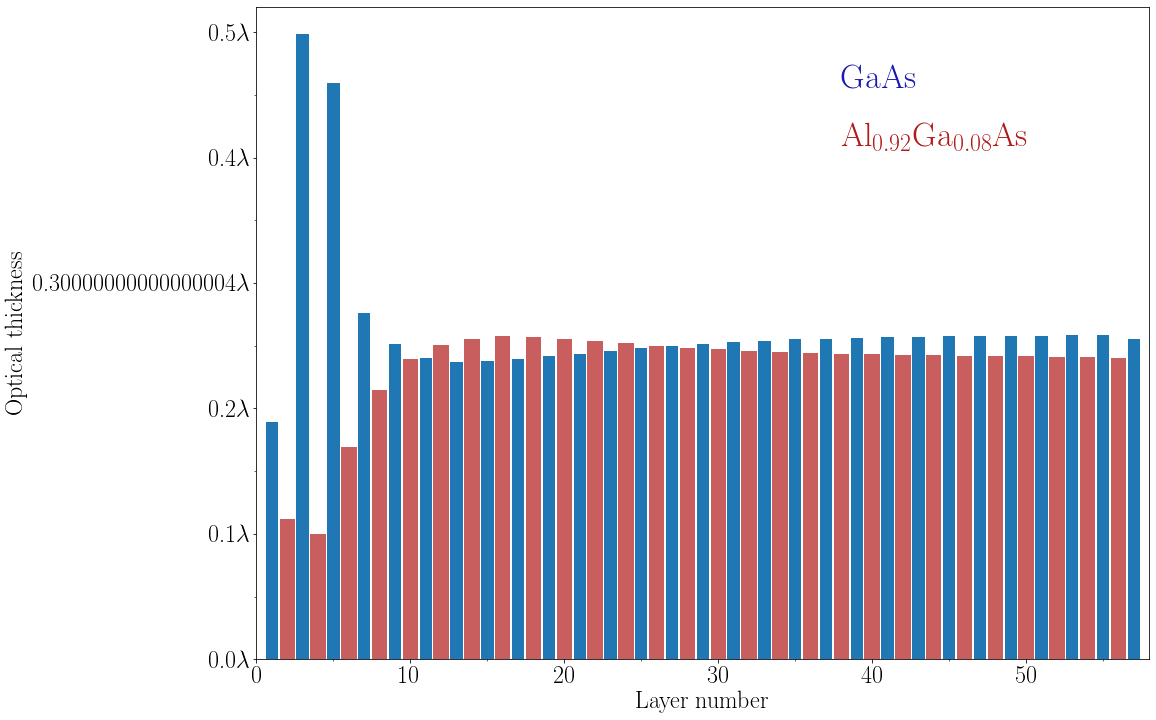

In [8]:
if isnotebook():
    plt.figure(figsize=(16,12))
    thelen = np.arange(1, 1+len(optThicknessArr))
    fmtDict = {'width': 1, 'align': 'center', 'alpha': 0.7, 'linewidth': 0.5}
    cc1 = (0.1, 0.1, 0.7)
    cc2 = (0.7, 0.1, 0.1)
    plt.bar(thelen[0::2], unp.nominal_values(optThicknessArr[0::2])) #, color=cc1, **fmtDict)
    plt.bar(thelen[1::2], unp.nominal_values(optThicknessArr[1::2]), color=cc2, **fmtDict)
    plt.text(38, 0.455, 'GaAs', color=cc1)
    plt.text(38, 0.405, 'Al$_{0.92}$Ga$_{0.08}$As', color=cc2)
    ax = plt.gca()
    ax.set_yticks(np.arange(0, 0.6, 0.05), minor=True)
    ax.set_xticks(np.arange(0, 61, 5), minor=True)
    theticks = list(plt.yticks()[0])
    theticklabels = [str(x) + '$\lambda$' for x in theticks]
    plt.yticks(theticks, theticklabels)
    plt.grid()
    plt.xlim(0, 58)
    plt.ylim(0, 0.52)
    plt.xlabel('Layer number')
    plt.ylabel('Optical thickness')
    #if qwl==False:
    #    fname = 'algaas_optical_structure.pdf'
    #    plt.savefig(fname, bbox_inches='tight')
    #    os.system('epstopdf ' + fname)
    #    os.system('rm ' + fname)

## Effective parameters: $\alpha_\mathrm{c}$, $C_\mathrm{c}$, $\kappa_\mathrm{c}$, $\beta_\mathrm{c}$, and others

Now we compute some of the &ldquo;effective&rdquo; coating and substrate parameters, which are various averages involving the above arrays.

In [9]:
coatThickness = np.sum(physThicknessArr)
coatYoung = uf(100, 20) * 1e9 # Pa
coatPoisson = 0.311 * uf(1, 0.2) # dimensionless
CTEeffArr = CTEArr * (1+subPoisson)/(1-poissonArr) \
            * ((1+poissonArr)/(1+subPoisson) + (1 - 2*subPoisson) * youngArr/subYoung)
CTEYamaArr = CTEArr * (1+poissonArr)/(1-poissonArr)
coatCTE = np.sum(CTEeffArr * physThicknessArr/coatThickness)
coatCTEyama = np.sum(CTEYamaArr * physThicknessArr/coatThickness)
subEffCTE = 2*subCTE*(1+subPoisson)
coatHeatCap = np.sum(heatCapArr * physThicknessArr/coatThickness)
coatCond = np.sum(condArr**-1 * physThicknessArr/coatThickness)**-1
fTherm = subCond / (np.pi * spotSize**2 * subHeatCap) # Hz
print('Coating thickness: {0:.5g} um'.format(coatThickness * 1e6))
print('Coating CTE [Evans]: {0:.3g} K**-1'.format(coatCTE))
print('Coating CTE [Yamamoto]: {0:.3g} K**-1'.format(coatCTE))
print('Coating heat capacity: {0:.3g} J/(m**3 * K)'.format(coatHeatCap))
print('Coating conductivity: {0:.3g} W/(m*K)'.format(coatCond))
print('Substrate effective CTE: {0:.3g} K**-1'.format(subEffCTE))
print('Thermal relaxation frequency: {0:.3g} Hz'.format(fTherm))

Coating thickness: 4.6806+/-0.0004 um
Coating CTE [Evans]: (1.96+/-0.25)e-05 K**-1
Coating CTE [Yamamoto]: (1.96+/-0.25)e-05 K**-1
Coating heat capacity: (1.72+/-0.05)e+06 J/(m**3 * K)
Coating conductivity: 61.6+/-2.4 W/(m*K)
Substrate effective CTE: (1.19+/-0.07)e-06 K**-1
Thermal relaxation frequency: 5.92+/-0.93 Hz


In the next few cells we compute the coating's effective thermorefractive coefficient $\beta_c$.
The calculation follows Evans et al. (2008).
Since the python `uncertainties` package doesn't handle complex numbers, done this computation using the $2\times2$ matrix representation of complex numbers instead.

The effective reflectivity of layer $k$ is
$$ \overline{r}_k = \mathrm{e}^{-\mathrm{i}\phi_k} r_{k,k+1,\ldots,N} = \mathrm{e}^{-\mathrm{i}\phi_k}
    \frac{r_k + \overline{r}_{k+1}}{1 + r_k \overline{r}_{k+1}}, $$
with the base case $\overline{r}_N = \mathrm{e}^{-\mathrm{i}\phi_N} r_{N,\mathrm{s}}$.
The overall coating reflectivity is $\overline{r}_0$.

In [10]:
def cMat(a, b):
    return np.matrix([[a, -b], [b, a]])
refIndAugArr = np.concatenate([[1], refIndArr, [subRefInd]])
reflectArr = (refIndAugArr[:-1] - refIndAugArr[1:]) / (refIndAugArr[:-1] + refIndAugArr[1:])
phiRTArr = 4*np.pi/lam * refIndArr * physThicknessArr
phiRTArr = np.concatenate([[0], phiRTArr])
# Now the array syntax gets a bit messy because the uncertainties package
# can't handle complex numbers...
reflectEffArr = unp.uarray(np.zeros((2, len(reflectArr))), 0)
reflectEffArr[:,-1] = np.array([unp.cos(phiRTArr[-1]), -unp.sin(phiRTArr[-1])]) * reflectArr[-1]

for kk in range(len(physThicknessArr)-1, -1, -1):
    thisMat = cMat(unp.cos(phiRTArr[kk]), -unp.sin(phiRTArr[kk])) \
              * (cMat(reflectArr[kk], 0) + cMat(*reflectEffArr[:,kk+1])) \
              * unp.ulinalg.inv(cMat(1, 0) + cMat(reflectArr[kk], 0) * cMat(*reflectEffArr[:,kk+1]))
    #reflectEffArr[:,kk] = thisMat[0,:]
    reflectEffArr[0,kk] = thisMat[0,0]
    reflectEffArr[1,kk] = thisMat[1,0]
     
drEffdPhiArr = unp.uarray(np.zeros((2, len(reflectEffArr[0]))), 0)
for kk in range(len(physThicknessArr)-1, -1, -1):
    drEffdPhiArr[0, kk] = reflectEffArr[1, kk+1]
    drEffdPhiArr[1, kk] = -reflectEffArr[0, kk+1]
    for jj in range(kk, -1, -1):
        mymat = cMat(unp.cos(phiRTArr[jj]), -unp.sin(phiRTArr[jj])) \
            * (cMat(1, 0) - cMat(reflectArr[jj], 0)**2) \
            * unp.ulinalg.inv(cMat(1, 0) + cMat(reflectArr[jj], 0) * cMat(*reflectEffArr[:,jj+1]))**2 \
            * cMat(*drEffdPhiArr[:, kk])
        drEffdPhiArr[0, kk] = mymat[0, 0]
        drEffdPhiArr[1, kk] = mymat[1, 0]

KeyboardInterrupt: 

In [ ]:
if isnotebook():
    plt.figure(figsize=(16,12))
    plt.plot(unp.nominal_values(reflectArr), 'bo', alpha=0.8, label=r'$r$')
    plt.plot(unp.nominal_values(unp.cos(phiRTArr)), 'ro', alpha=0.8, label=r'$\cos(\phi_\mathrm{rt})$')
    plt.plot(unp.nominal_values(reflectEffArr[0]), 'yo', alpha=0.8, label=r'$\Re[\overline{r}]$')
    plt.plot(unp.nominal_values(reflectEffArr[1]), 'mo', alpha=0.8, label=r'$\Im[\overline{r}]$')
    plt.grid()
    plt.ylim(-1.05, 1.05)
    plt.legend(numpoints=1, framealpha=0.6)
    plt.xlabel('Layer number')
    plt.ylabel('Value')

In [ ]:
if isnotebook():
    plt.plot(unp.nominal_values(drEffdPhiArr[1, :]), 'o', alpha=0.6)
    plt.grid()

In [16]:
dPhiCoatdPhi = unp.uarray(np.zeros(len(physThicknessArr)), 0)
for jj in range(len(dPhiCoatdPhi)):
    thisMat = unp.ulinalg.inv(cMat(*reflectEffArr[:,0])) * cMat(*drEffdPhiArr[:,jj])
    dPhiCoatdPhi[jj] = thisMat[0,1]
dPhiCoatdT = unp.uarray(np.zeros(len(reflectEffArr[0])), 0)
dPhiCoatdT[0] = dPhiCoatdPhi[0] * (-4*np.pi/lam) * coatCTE * coatThickness
dPhiCoatdT[1:] = dPhiCoatdPhi[0:] * (4*np.pi/lam) \
                 * (CTRArr + CTEeffArr * refIndArr) * physThicknessArr
#dPhiCoatdT[1:] = dPhiCoatdPhi[0:] * (4*np.pi/lam) \
#                 * (CTRArr + CTEYamaArr * refIndArr) * physThicknessArr
coatCTR = 1/(4*np.pi) * np.sum(dPhiCoatdT[1:])
#coatCTR = uf(7.9,0.1)*1e-5
DelCTE = coatCTE - subEffCTE*coatHeatCap/subHeatCap
print('Coating CTR: {0:.2uS} K**-1'.format(coatCTR))
print(r'Covariance matrix of $\Delta\alpha_c$ and $\beta_c$:')
print(unc.correlation_matrix((DelCTE, coatCTR)))

LinAlgError: Singular matrix

In [11]:
coatCTR = 8.297262791530789e-05
DelCTE = coatCTE - subEffCTE*coatHeatCap/subHeatCap

Now we make a comparison with analytical formulas for a simple QWL coating [Evans et al. 2008, &sect;B3]. These parameters will *not* coincide with our optimized coating parameters.

In [12]:
algaxB = algaxCTR + algaxCTEyama*algaxRefInd
gaasB = gaasCTR + gaasCTEyama*gaasRefInd
coatCTRevans = (gaasB + algaxB*(2*(gaasRefInd/algaxRefInd)**2-1))/(4*(gaasRefInd**2-algaxRefInd**2))
print('QWL coating CTR [Evans eq. B20]: {:.3uS} K**-1'.format(coatCTRevans))
print('B_L and B_H [Evans eq. B15]: {0:.3uS} K**-1, {1:.3uS} K**-1'.format(algaxB, gaasB))
print('QWL coating reflectivity: {:.3uS}'.format(1-abs(reflectEffArr[0,0])**2))

QWL coating CTR [Evans eq. B20]: 5.941(415)e-05 K**-1
B_L and B_H [Evans eq. B15]: 0.00020959(883) K**-1, 0.00040553(972) K**-1
QWL coating reflectivity: 1.0(0)


# Noise traces

## Beat measurement

We load some measured data and plot it.

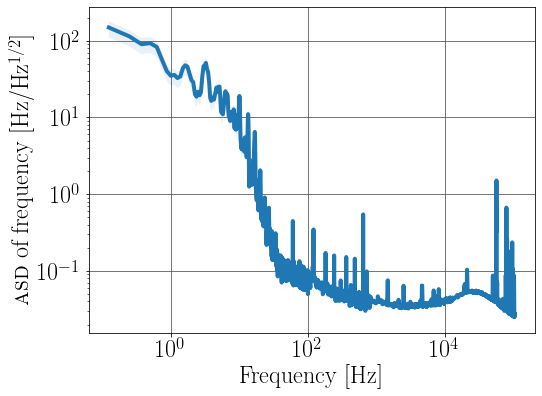

In [13]:
avgList = [10, 30, 300, 1000]
beatCal = 1e3/np.sqrt(2) # Hz/V
ff0, beat0 = np.loadtxt('../Data/beat0.txt', unpack=1)
ff1, beat1 = np.loadtxt('../Data/beat1.txt', unpack=1)
ff2, beat2 = np.loadtxt('../Data/beat2.txt', unpack=1)
ff3, beat3 = np.loadtxt('../Data/beat3.txt', unpack=1)

beat0 = unp.uarray(beat0**2, beat0**2/np.sqrt(avgList[0]/2))
beat1 = unp.uarray(beat1**2, beat1**2/np.sqrt(avgList[1]/2))
beat2 = unp.uarray(beat2**2, beat2**2/np.sqrt(avgList[2]/2))
beat3 = unp.uarray(beat3**2, beat3**2/np.sqrt(avgList[3]/2))

ff = np.concatenate([ff0,
                    ff1[ff1>ff0[-1]],
                    ff2[ff2>ff1[-1]],
                    ff3[ff3>ff2[-1]]])
beatPSD = np.concatenate([beat0,
                    beat1[ff1>ff0[-1]],
                    beat2[ff2>ff1[-1]],
                    beat3[ff3>ff2[-1]]])
beatPSD *= beatCal**2
if isnotebook():
    hBeat = plt.figure(figsize=(8,6))
    ax = hBeat.add_subplot(111)
    ax.loglog(ff, np.sqrt(unp.nominal_values(beatPSD)))
    ax.fill_between(ff, np.sqrt(unp.nominal_values(beatPSD)-unp.std_devs(beatPSD)),
                    np.sqrt(unp.nominal_values(beatPSD)+unp.std_devs(beatPSD)), alpha=0.1)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(r'\textsc{asd} of frequency [Hz/Hz$^{1/2}$]')

In [16]:
np.savetxt('AlGaAsMeasurement.txt', np.c_[ff, np.sqrt(unp.nominal_values(beatPSD))])

## Coating Brownian noise

Nakagawa expression:

$$S_x^{\text{(cBr)}}(f) = \frac{4 k_\text{B} T}{\pi^2 f} \frac{(1+\sigma_\text{s})(1-2\sigma_\text{s})d}{w^2 E_\text{s}}\phi_\text{c}$$

Harry (eq. 21) expression (assuming $\phi_\perp = \phi_\parallel$) [see Cole et al.]:

$$ S_x^{\text{(cBr)}}(f) = \frac{2 k_\text{B} T}{\pi^2 f} \frac{d \phi_\text{c}}{w^2 E_\text{s}^2 E_\text{c}(1-\sigma_\text{c}^2)}
\left[E_\text{c}^2 (1+\sigma_\text{s})^2 (1-2\sigma_\text{s})^2
   + E_\text{s}^2 (1+\sigma_\text{c})^2(1-2\sigma_\text{c})\right]$$


In [14]:
coatBrownianPSD1 = (4*scc.Boltzmann*temp) / (np.pi**2 * ff) * (1+subPoisson) * (1-2*subPoisson) \
                  * coatThickness * coatLoss / (spotSize**2 * subYoung)
coatBrownianPSD = (2*scc.Boltzmann*temp) / (np.pi**2 * ff) * coatThickness / (spotSize**2 * subYoung**2) \
                  * coatLoss / (coatYoung * (1-coatPoisson**2)) * (coatYoung**2 * (1+subPoisson)**2 * (1-2*subPoisson)**2 \
                  + subYoung**2 * (1+coatPoisson)**2 * (1-2*coatPoisson))

## Substrate Brownian noise

Substrate Brownian noise is [Cole et al. 2013]
$$S_x^{\text{(sBr)}}(f) = \frac{2 k_\text{B} T}{\pi^{3/2} f} \frac{1-\sigma_\text{s}^2}{w E_\text{s}}\phi_\text{s}$$

In [15]:
subBrownianPSD = (2*scc.Boltzmann*temp) / (np.pi**1.5 * ff) * (1-subPoisson**2) * subLoss / (spotSize * subYoung)

## Coating thermo-optic noise

### Temperature PSD

The profile-weighted temperature fluctuation PSD is
$$ S_T(f) = \frac{2^{3/2} k_\text{B} T^2}{\pi\kappa_\text{s}w}M(f/f_\text{T})$$
with
$$ M(\Omega) = \Re\left[\int\limits_0^\infty\! \mathrm{d}u\, \frac{u\ \mathrm{e}^{-u^2/2}}{\left(u^2-\mathrm{i}\Omega\right)^{1/2}}\right].$$

In [16]:
def integrandM(uu, Omega):
    Omega = unp.nominal_values(Omega)
    return np.real(uu * np.exp(-uu**2/2) / np.sqrt(uu**2 - 1j*Omega))

In [17]:
fShort = np.logspace(-1, 5, 100)
integralM = np.zeros(len(fShort))
for ii in range(len(integralM)):
    integralM[ii] = scint.quad(integrandM, 0, np.inf,
                               args=(unp.nominal_values(fShort[ii]/fTherm),))[0]
    clear_output()
    print('Now doing {0:.0f} of {1:.0f}: f = {2:.4g} Hz'.format(ii+1, len(fShort), fShort[ii]))
    sys.stdout.flush()
integralM = np.interp(ff, fShort, integralM)

Now doing 100 of 100: f = 1e+05 Hz


In [18]:
tempPSD = 2**1.5 * scc.Boltzmann * temp**2 * integralM / (np.pi * subCond * spotSize)

### Thick coating correction

This follows Evans et al. (2008).

Defining $R = \sqrt{\kappa_\text{c} C_\text{c} / \kappa_\text{s} C_\text{s}}$ and $\xi = \sqrt{4\pi f C_\text{c}/\kappa_\text{c}}d$, we have

$$\begin{align}
    \Gamma_0 &= 2(\sinh\xi - \sin\xi) + 2R(\cosh\xi - \cos\xi) \\
    \Gamma_1 &= 8\sin(\xi/2)\,[r_T \cosh(\xi/2) + \sinh(\xi/2)] \\
    \Gamma_2 &= (1+R^2)\sinh(\xi) + (1-R^2)\sin(\xi) + 2 R \cosh(\xi) \\
    \Gamma_D &= (1+R^2)\cosh(\xi) + (1-R^2)\cos(\xi) + 2 R \sinh(\xi)
\end{align}$$

Then the thick coating correction factor is
$$\Gamma_\text{tc} = \frac{p_\text{E}^2 \Gamma_0 + p_\text{E} p_\text{R} \xi \Gamma_1 + p_\text{R}^2 \xi^2 \Gamma_2}{R\xi^2 \Gamma_D},$$
where
$$p_\text{E} = \frac{\Delta\alpha\ d}{\Delta\alpha\ d-\beta_\text{c}\lambda} \quad\text{and}\quad
p_\text{R} = \frac{-\beta_\text{c}\lambda}{\Delta\alpha\ d-\beta_\text{c}\lambda}.$$

In [19]:
rTherm = unp.sqrt(coatCond * coatHeatCap / (subCond * subHeatCap))
xi = unp.sqrt(4*np.pi*ff*coatHeatCap / coatCond) * coatThickness
pR = -coatCTR*lam / (DelCTE*coatThickness - coatCTR*lam)
pE = DelCTE*coatThickness / (DelCTE*coatThickness - coatCTR*lam)
Gamma0 = 2 * (unp.sinh(xi) - unp.sin(xi)) + 2*rTherm * (unp.cosh(xi) - unp.cos(xi))
Gamma1 = 8 * unp.sin(xi/2) * (rTherm*unp.cosh(xi/2) + unp.sinh(xi/2))
Gamma2 = (1 + rTherm**2) * unp.sinh(xi) + (1 - rTherm**2) * unp.sin(xi) + 2*rTherm * unp.cosh(xi)
GammaD = (1 + rTherm**2) * unp.cosh(xi) + (1 - rTherm**2) * unp.cos(xi) + 2*rTherm * unp.sinh(xi)
GammaTC = (pE**2 * Gamma0 + pE*pR*xi*Gamma1 + pR**2 * xi**2 * Gamma2) / (rTherm * xi**2 * GammaD)

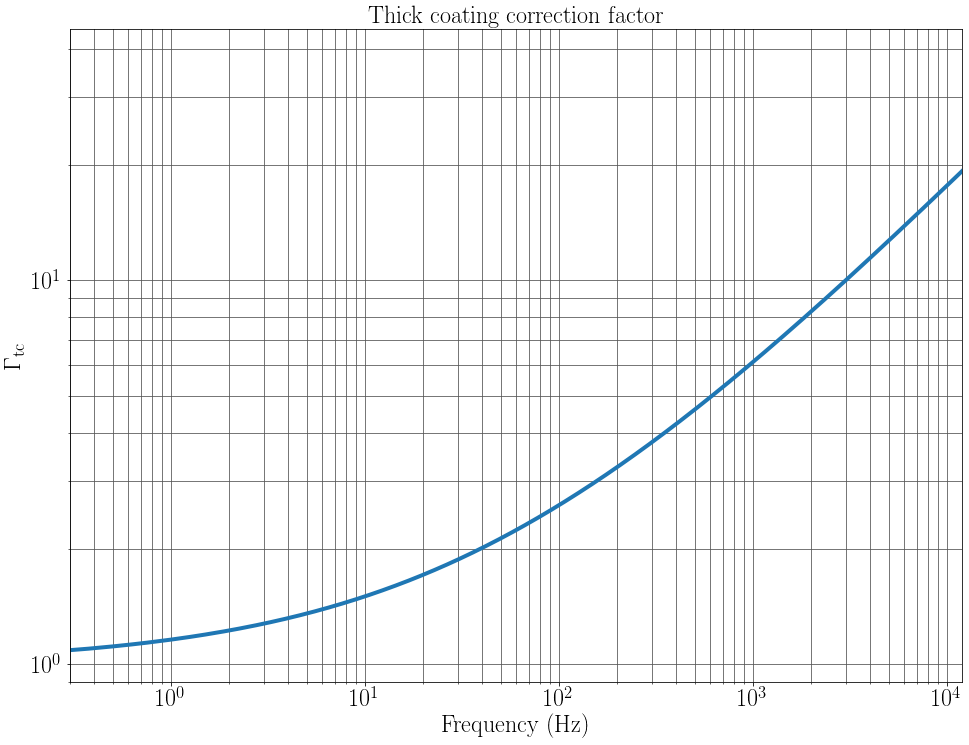

In [20]:
if isnotebook():
    plt.loglog(ff, unp.nominal_values(GammaTC))
    plt.xlabel(r'Frequency (Hz)')
    plt.ylabel(r'$\Gamma_\mathrm{tc}$')
    plt.xlim([0.3, 12e3])
    plt.ylim([0.9, 45])
    plt.title('Thick coating correction factor')
    plt.grid('on', which='both')
    plt.grid(which='major', linestyle='solid')

### Thermo-optic, thermoelastic, and thermorefractive noises

In [21]:
coatThermoOpticPSD = tempPSD * GammaTC * (DelCTE*coatThickness - coatCTR*lam)**2 # m**2/Hz
coatThermoElasticPSD = tempPSD * (DelCTE*coatThickness)**2 # m**2/Hz
coatThermoRefractivePSD = tempPSD * (coatCTR*lam)**2 # m**2/Hz

## Substrate thermoelastic noise

Cerdonio eq. 20:

$$ S_{\hat u}(\omega) = \frac{8}{(2\pi)^{1/2}} \alpha^2 (1+\sigma)^2 \frac{k_\text{B} T^2 r_0}{\rho\mathcal{C}a^2} J(\omega/\omega_\text{c}) $$
with $a^2 = \kappa/(\rho\mathcal{C})$, $r_0 = w/\sqrt{2}$, and

$$ J(\Omega) = \left(\frac{2}{\pi^3}\right)^{1/2} \int\limits_0^\infty \mathrm{d} u \int\limits_{-\infty}^\infty \mathrm{d} v \frac{u^3 \mathrm{e}^{-u^2/2}}{(u^2+v^2)\left[(u^2+v^2)^2+\Omega^2\right]}$$

(note the typo in the prefactor in Cerdonio). Alternatively, Somiya (PRD 82 127101) provides an analytical expression:

$$ J(\Omega) = -\operatorname{Re}\left\{\frac{\mathrm{e}^{\mathrm{i}\Omega/2}}{\Omega^2} (1 - \mathrm{i}\Omega)\, (\operatorname{erfc}\!{\left[\frac{\Omega^{1/2}(1+\mathrm{i})}{2}\right]} -1 )\right\} + \frac{1}{\Omega^2} - \frac{1}{(\pi\Omega^3)^{1/2}}$$

Substrate thermoelastic noise is
$$ S_x^{\text{(subTE)}}(f) = \frac{4 k_\text{B} T^2}{\pi^{1/2}}
    \frac{\alpha_\text{s}^2 (1+\sigma_\text{s})^2 w}{\kappa_\text{s}}
    J(f/f_\text{T})$$

In [22]:
somiyaW = unp.nominal_values(ff/fTherm)

In [23]:
somiyaJ = -np.real(np.exp(1j*somiyaW/2)*(1-1j*somiyaW)/somiyaW**2
                   * scsp.erfc(np.sqrt(somiyaW)*(1+1j)/2)) + somiyaW**-2 \
                  - (np.pi*somiyaW**3)**-0.5

Now we plot $J$ along with its asymptotic behaviors, just to make sure we've done the computation correctly.

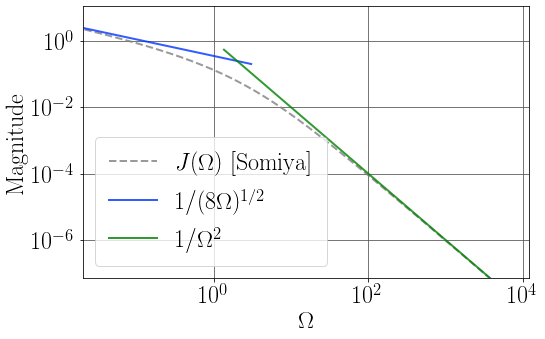

In [24]:
hIntegralJ = plt.figure(figsize=(8,5))
ax = hIntegralJ.add_subplot(111)
ax.loglog(somiyaW, somiyaJ, '--', c=(0.5, 0.5, 0.5), alpha=0.8, lw=2,
          label=r'$J(\Omega)$ [Somiya]')
ffLow = ff[ff<=18]
JLow = 2 / (3*np.sqrt(np.pi*ffLow/fTherm.nominal_value))
JLow = 1/np.sqrt(8*ffLow/fTherm.nominal_value)
ffHigh = ff[ff>=8]
JHigh = 1/(ffHigh/fTherm.nominal_value)**2
if isnotebook():
    ax.loglog(ffLow/fTherm.nominal_value, JLow, c=(0, 0.2, 1), alpha=0.8, lw=2,
              label=r'$1/(8 \Omega)^{1/2}$')
    ax.loglog(ffHigh/fTherm.nominal_value, JHigh, c=(0, 0.5, 0), alpha=0.8, lw=2,
              label=r'$1/\Omega^2$')
    ax.legend(loc='best')
    ax.grid(which='major', linestyle='solid')
    ax.set_xlim([0.02, 12e3])
    ax.set_ylim([7e-8, 11])
    ax.set_xlabel('$\Omega$')
    ax.set_ylabel('Magnitude')

In [25]:
subThermoelasticPSD = 4*scc.Boltzmann*temp**2 / np.sqrt(np.pi) * subCTE**2 * (1+subPoisson)**2 * spotSize/subCond * somiyaJ

KeyboardInterrupt: 

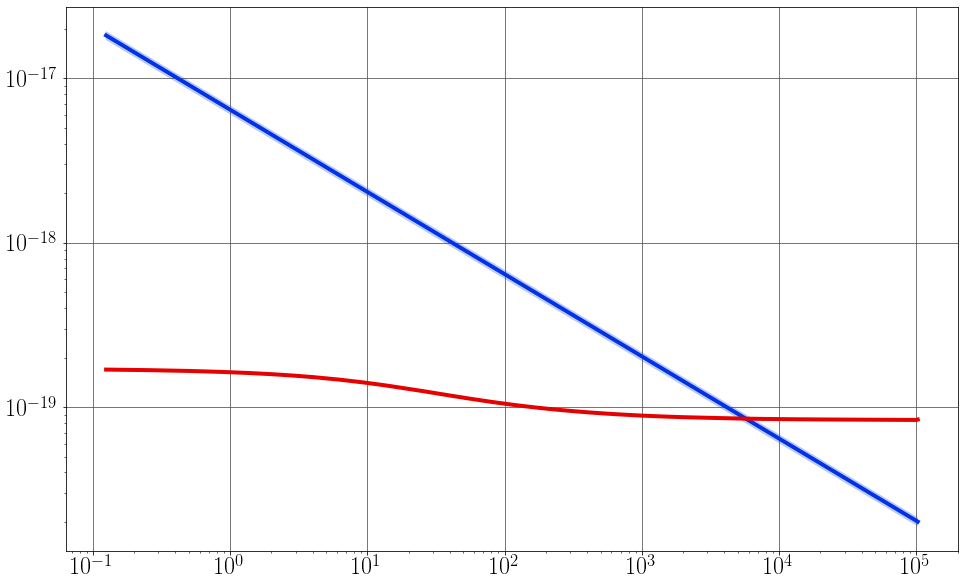

In [26]:
if isnotebook():
    hTO = None
    hTO = plt.figure(figsize=(16, 10))
    ax = hTO.add_subplot(111)
    tracesTO = [coatBrownianPSD, coatThermoOpticPSD, coatThermoElasticPSD, coatThermoRefractivePSD, subThermoelasticPSD]
    labelsTO = ['Coating Brownian', 'Coating TO', 'Coating TE', 'Coating TR', 'Substrate TE']
    colorsTO = cList[:]
    colorsTO[3] = 'None'
    ecTO = cList[:]
    lsTO = ['solid', 'solid', 'solid', 'dashed', 'solid']
    hatchesTO = ['', '', '', '////', '']
    for ii, trace in enumerate(tracesTO):
        ax.loglog(ff, unp.nominal_values(unp.sqrt(trace)),
                  label=labelsTO[ii], color=cList[ii], ls=lsTO[ii])
        if hatchesTO[ii] == '':
            ax.fill_between(ff, np.sqrt(np.max([unp.nominal_values(trace) - unp.std_devs(trace), np.ones(len(trace))*1e-42], axis=0)),
                        np.sqrt(unp.nominal_values(trace) + unp.std_devs(trace)),
                        alpha=0.2, color=colorsTO[ii], linestyle=lsTO[ii],
                        edgecolor=ecTO[ii], hatch=hatchesTO[ii])
        else:
            ax.fill_between(ff, np.sqrt(np.max([unp.nominal_values(trace) - unp.std_devs(trace), np.ones(len(trace))*1e-42], axis=0)),
                        np.sqrt(unp.nominal_values(trace) + unp.std_devs(trace)),
                        alpha=0.7, color=colorsTO[ii], linestyle=lsTO[ii],
                        edgecolor=ecTO[ii], hatch=hatchesTO[ii])
    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel(r'ASD of displacement / $\bigl(\mathrm{m/Hz}^{1/2}\bigr)$')
    ax.legend(loc='upper right', framealpha=0.7)
    ax.grid(which='major', linestyle='solid', color=(0.2, 0.2, 0.2), alpha=0.7, zorder=0)
    ax.grid(which='minor', linestyle='dotted', color=(0.2, 0.2, 0.2), alpha=0.7, zorder=0)
    ax.set_xlim(0.3, 12e3)
    ax.set_ylim(9e-21, 2.8e-17)
    hTO.tight_layout()
    if qwl==True:
        hTO.savefig('ThermoOpticPlotQWL.pdf')
        np.savetxt('coatThermoOpticQWL.pdf', np.c_[ff, unp.nominal_values(coatThermoOpticPSD),
                                          unp.std_devs(coatThermoOpticPSD)],
                  header='Frequency (Hz)\t Nom. of PSD (m/rtHz)\t Std. of PSD (m/rtHz)')
    else:
        hTO.savefig('ThermoOpticPlot.pdf')

## PDH shot noise

Given a visbility $\eta$ and a PDH modulation index $\Gamma$, the PDH shot noise level (in W$^2$/Hz) is
$$ S_L^\text{(PDHshot)} = 2h\nu P_0 \left[J_0(\Gamma)^2 (1-\eta) +3 J_1(\Gamma)^2\right] $$

In [27]:
# We'll use unc.wrap to make uncertainties-compatible Bessel functions
wrapj0 = unc.wrap(scsp.j0)
wrapj1 = unc.wrap(scsp.j1)
# Compute the shot noise PSD
pdhShotPSD = 2*scc.Planck*scc.c/lam * powInc * (wrapj0(pdhModInd)**2 * (1-cavVis) + 3*wrapj1(pdhModInd)**2)
# Now account for the cavity pole and convert from power to frequency
pdhShotPSD *= (1+(ff/cavPole)**2) / pdhSlope**2

## Residual NPRO frequency noise

We need a true free-running frequency noise measurement. In the meantime, we assume a frequency noise with ASD $\sqrt{S_{\nu}(f)} = (10^4 \text{ Hz/Hz}^{-1/2})\times(1 \text{ Hz}/f)$.

In [28]:
# NPRO free-running frequency noise ASD: Willke et al., Opt. Lett. vol 25 no 14
# PDH OLTFs: ctn:1504
nproFreeASD = 10**4/ff # Hz/Hz**0.5
# Load vector-fitted versions of PDH OLTF data
with open('../Data/pdhNorthLTI.json', 'r') as fnorth:
    pdhNorthDict = json.load(fnorth)
with open('../Data/pdhSouthLTI.json', 'r') as fsouth:
    pdhSouthDict = json.load(fsouth)
pdhNorthZpk = (np.array(pdhNorthDict['zeros.real'])+1j*np.array(pdhNorthDict['zeros.imag']),
               np.array(pdhNorthDict['poles.real'])+1j*np.array(pdhNorthDict['poles.imag']),
               pdhNorthDict['gain.real']+1j*pdhNorthDict['gain.imag'])
pdhSouthZpk = (np.array(pdhSouthDict['zeros.real'])+1j*np.array(pdhSouthDict['zeros.imag']),
               np.array(pdhSouthDict['poles.real'])+1j*np.array(pdhSouthDict['poles.imag']),
               pdhSouthDict['gain.real']+1j*pdhSouthDict['gain.imag'])
pdhNorthLTI = scipy.signal.lti(*pdhNorthZpk)
pdhSouthLTI = scipy.signal.lti(*pdhSouthZpk)
_, pdhNorthMag, pdhNorthPha = pdhNorthLTI.bode(w=2*np.pi*ff)
_, pdhSouthMag, pdhSouthPha = pdhSouthLTI.bode(w=2*np.pi*ff)
pdhNorthMag = 10**(pdhNorthMag/20)
pdhSouthMag = 10**(pdhSouthMag/20)
northResidFreqPSD = (nproFreeASD / pdhNorthMag)**2
southResidFreqPSD = (nproFreeASD / pdhSouthMag)**2
residFreqPSD = northResidFreqPSD + southResidFreqPSD

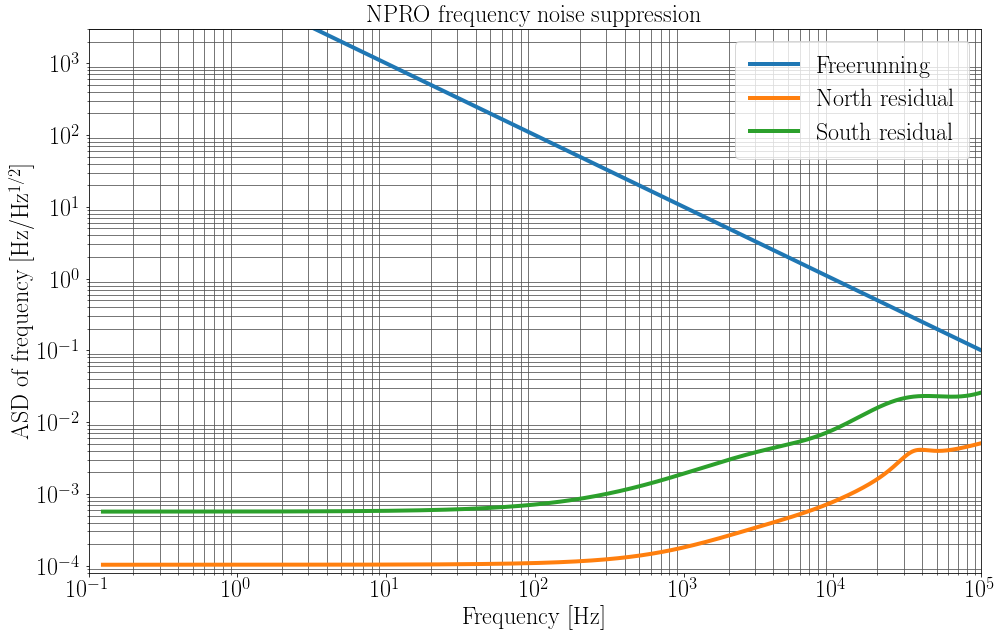

In [29]:
# Here we're assuming the loops are gain-limited...
if isnotebook():
    hResidFreq = plt.figure(figsize=(16, 10))
    ax = hResidFreq.add_subplot(111)
    ax.loglog(ff, nproFreeASD, label='Freerunning')
    ax.loglog(ff, np.sqrt(northResidFreqPSD), label='North residual')
    ax.loglog(ff, np.sqrt(southResidFreqPSD), label='South residual')
    ax.grid(which='both')
    ax.legend()
    ax.set_title(r'NPRO frequency noise suppression')
    ax.set_xlabel(r'Frequency [Hz]')
    ax.set_ylabel(r'ASD of frequency [Hz/Hz$^{1/2}$]')
    ax.set_xlim(0.1, 1e5)
    ax.set_ylim(8e-5, 3e3)

## Photothermal noise

Farsi et al. (2012), eq. A51:

\begin{equation}
    H(f) = H_\text{c}(f) + H_\text{s}(f) + H_\text{tr}(f).
\end{equation}

The photothermal noise $S_x(f)$ of a single mirror is then related to the incident power fluctuation $S_P(f)$ by $S_x(f) = |H(f)|^2 \mathcal{A}^2 S_P(f)$, where $\mathcal{A}$ is the mirror's absorptivity.

### Definitions

We define the following:
* $d$ is the coating thickness,
* $r_0$ is the radius satisfying $I(r_0) = I_0/\mathrm{e}$ (so $w = \sqrt{2}r_0$),
* $C$ has units of J/(m$^3$ K)

### Coating contribution

Farsi eq. A44:

\begin{equation}
    H_\text{c}(f) = \frac{\alpha_\text{c}}{\pi\kappa_\text{c}}
        \frac{f_\text{c}}{\mathrm{i}f}
        \int\limits_0^\infty \mathrm{d}\xi \, \xi \, \mathrm{e}^{-\xi^2/2} \,
        P_\text{abs}(f) \, F(\xi) \,
        \left[\gamma_1 G_1(\xi) - \gamma_2 \frac{\xi}{\xi_\text{c}} G_2(\xi) \right],
\end{equation}
where
\begin{align}
    \xi &= k_\perp r_0 \\
    G_1(\xi) &= \cosh(\xi d/r_0) + \mathcal{R}\frac{\xi}{\xi_\text{c}}\sinh(\xi d/r_0) - \cosh(\xi_\text{c} d/r_0) - \mathcal{R}\sinh(\xi_\text{c} d/r_0) \\
    G_2(\xi) &= \mathcal{R} \cosh(\xi d/r_0) + \frac{\xi_\text{c}}{\xi} \sinh(\xi d/r_0) - \mathcal{R} \cosh(\xi_\text{c} d/r_0) - \sinh(\xi_\text{c} d/r_0) \\
    \xi_x &= \left(\frac{\mathrm{i}f}{f_x} + \xi^2\right)^{1/2} \qquad \text{with $x = {} $c, s} \\
    f_x &= \frac{\kappa_x}{\pi C_x w^2} = \frac{\kappa_x}{2\pi C_x r_0^2} \\
    F(\xi) &= \left[\cosh(\xi_\text{c} d/r_0) + \mathcal{R} \sinh(\xi_\text{c} d/r_0)\right]^{-1} \\
    \gamma_1 &\simeq \frac{1}{2}\,\frac{1+\sigma_\text{c}}{1-\sigma_\text{c}}
        \left[ 1 + (1-2\sigma_\text{s}) \frac{1+\sigma_\text{s}}{1+\sigma_\text{c}}\,
            \frac{E_\text{c}}{E_\text{s}}\right] \\
    \gamma_2 &\simeq \frac{1-\sigma_\text{s}^{\,2}}{1-\sigma_\text{c}} \,
        \frac{E_\text{c}}{E_\text{s}} \\
    \mathcal{R} &= \frac{\kappa_\text{c}\bigl(k_\text{c}^2 + k_\perp^2\bigr)^{1/2}}{\kappa_\text{s}\bigl(k_\text{s}^2 + k_\perp^2\bigr)^{1/2}} = \frac{\kappa_\text{c}\bigl(r_0^2 k_\text{c}^2 + \xi^2\bigr)^{1/2}}{\kappa_\text{s}\bigl(r_0^2 k_\text{s}^2 + \xi^2\bigr)^{1/2}} \\
    k_x &= \left(2\pi\mathrm{i} f C_x/\kappa_x\right)^{1/2} \qquad \text{with $x = {} $c, s}
    \end{align}

In [30]:
gamma1 = unp.nominal_values(0.5 * (1+coatPoisson) / (1-coatPoisson)
         * (1 + (1-2*subPoisson) * (1+subPoisson)/(1+coatPoisson) * coatYoung / subYoung))
gamma2 = unp.nominal_values((1-subPoisson**2) / (1-coatPoisson)
                            * coatYoung / subYoung)
r0 = spotSize.nominal_value/np.sqrt(2)
coatFreq = unp.nominal_values(coatCond / (2 * np.pi * coatHeatCap * r0**2))
subFreq = unp.nominal_values(subCond / (2 * np.pi * subHeatCap * r0**2))
dNom = coatThickness.nominal_value

def kCoat(ff):
    return np.sqrt(2j*unp.nominal_values(np.pi*ff*coatHeatCap/coatCond))

def kSub(ff):
    return np.sqrt(2j*unp.nominal_values(np.pi*ff*subHeatCap/subCond))

def fancyR(xi, ff):
    return (unp.nominal_values(coatCond/subCond)
            * np.sqrt((r0**2 * kCoat(ff)**2 + xi**2)
                      / (r0**2 * kSub(ff)**2 + xi**2)))

def xiCoat(xi, ff):
    return np.sqrt(1j*ff/coatFreq + xi**2)

def xiSub(xi, ff):
    return np.sqrt(1j*ff/subFreq + xi**2)

def Ffunc(xi, ff):
    return (np.cosh(dNom/r0*xiCoat(xi, ff))
              + fancyR(xi, ff) * np.sinh(dNom/r0*xiCoat(xi, ff)))**-1

def G1func(xi, ff):
    return (np.cosh(xi*dNom/r0)
            + fancyR(xi, ff) * xi/xiCoat(xi, ff) * np.sinh(xi*dNom/r0)
            - np.cosh(dNom/r0*xiCoat(xi, ff))
            - fancyR(xi, ff) * np.sinh(dNom/r0*xiCoat(xi, ff)))

def G2func(xi, ff):
    return (fancyR(xi, ff) * np.cosh(xi*dNom/r0)
            + xiCoat(xi, ff)/xi * np.sinh(xi*dNom/r0)
            - fancyR(xi, ff) * np.cosh(dNom/r0*xiCoat(xi, ff))
            - np.sinh(dNom/r0*xiCoat(xi, ff)))

def integrandPTCoat(xi, ff):
    return (xi * np.exp(-xi**2/2) * Ffunc(xi, ff)
            * (gamma1 * G1func(xi, ff) - gamma2*xi/xiCoat(xi, ff) * G2func(xi, ff)))

def integrandPTCoatReal(xi, ff):
    return np.real(integrandPTCoat(xi, ff))

def integrandPTCoatImag(xi, ff):
    return np.imag(integrandPTCoat(xi, ff))

In [31]:
print(gamma1, gamma2)
print(coatFreq, subFreq)
print(coatCond, subCond)
print(coatHeatCap, subHeatCap)
print(spotSize, r0, coatCTE)

1.7296806966618283 1.9575471698113205
244.9657127984857 5.918280852044723
61.6+/-2.4 1.38+/-0.20
(1.72+/-0.05)e+06 (1.60+/-0.10)e+06
0.0002154+/-0.0000005 0.00015229716965016425 (1.96+/-0.25)e-05


In [32]:
integralPTCoat = np.zeros(len(fShort), dtype=np.complex)
integralPTCoatErr = np.zeros(len(fShort), dtype=np.complex)
for ii in range(len(integralPTCoat)):
    thisReal, thisRealErr = scint.quad(integrandPTCoatReal, 0, np.inf, args=(fShort[ii],),
                          epsabs=1e-8, epsrel=1e-5, limit=20)[:2]
    thisImag, thisImagErr = scint.quad(integrandPTCoatImag, 0, np.inf, args=(fShort[ii],),
                          epsabs=1e-8, epsrel=1e-5, limit=20)[:2]
    integralPTCoat[ii] = thisReal + 1j*thisImag
    integralPTCoatErr[ii] = thisRealErr + 1j*thisImagErr
    clear_output()
    print('Now doing {0:.0f} of {1:.0f}: f = {2:.4g} Hz'.format(ii+1, len(fShort), fShort[ii]))
    sys.stdout.flush()

Now doing 100 of 100: f = 1e+05 Hz


(5.6+/-0.4)e-06
(5.6+/-0.4)e-06 61.6+/-2.4 244.9657127984857


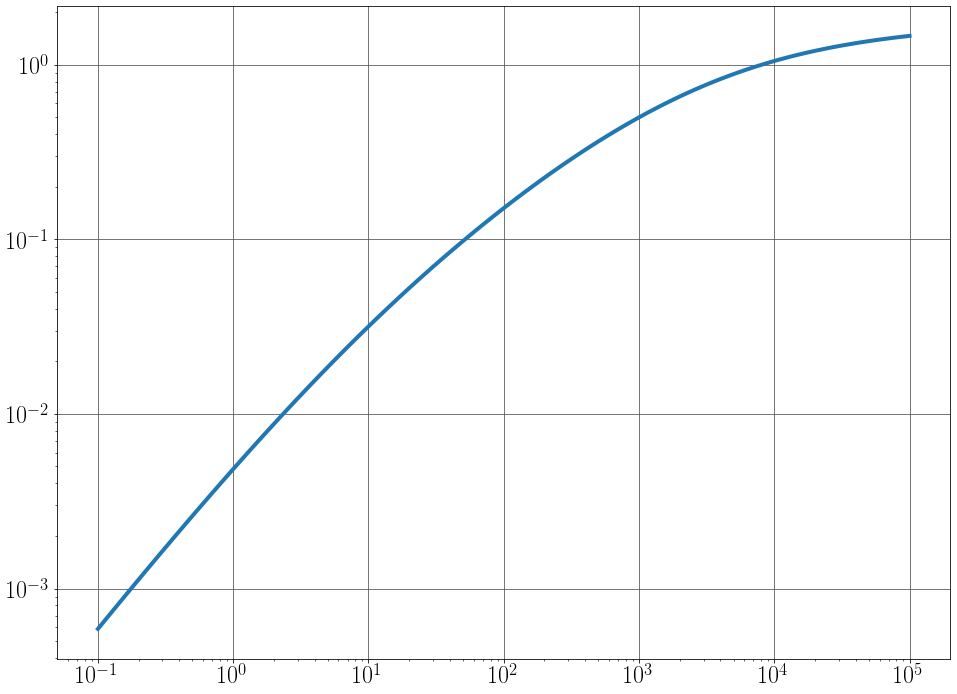

In [58]:
coatEffCTE = np.sum(CTEArr * physThicknessArr/coatThickness)
#coatEffCTE = coatCTE
print(coatEffCTE)
PTCoatTF = unp.nominal_values(coatEffCTE/(np.pi*coatCond)*coatFreq)/(1j*fShort)*integralPTCoat
if isnotebook():
    plt.loglog(fShort, np.abs(integralPTCoat))
print(coatEffCTE, coatCond, coatFreq)

### Substrate contribution

Farsi eq. A45:
\begin{equation}
    H_\text{s}(f) = -\frac{\alpha_\text{s}(1+\sigma_\text{s})}{\pi\kappa_\text{s}} \frac{f_\text{s}}{\mathrm{i}f}
        \int\limits_0^\infty \mathrm{d}\xi \, F(\xi) \,
       (1-\xi/\xi_\text{s}) \, \xi \, \mathrm{e}^{-\xi^2/2}\, P_\text{abs}(f)
\end{equation}

In [59]:
def integrandPTSub(xi, ff):
    return xi * np.exp(-xi**2/2) * Ffunc(xi, ff) * (1 - xi/xiSub(xi, ff))
def integrandPTSubReal(xi, ff):
    return np.real(integrandPTSub(xi, ff))
def integrandPTSubImag(xi, ff):
    return np.imag(integrandPTSub(xi, ff))

In [60]:
integralPTSub = np.zeros(len(fShort), dtype=np.complex)
integralPTSubErr = np.zeros(len(fShort))
for ii in range(len(integralPTSub)):
    thisReal = scint.quad(integrandPTSubReal, 0, np.inf, args=(fShort[ii],),
                          epsabs=1e-3, epsrel=1e-3, limit=20)[0]
    thisImag = scint.quad(integrandPTSubImag, 0, np.inf, args=(fShort[ii],),
                          epsabs=1e-3, epsrel=1e-3, limit=20)[0]
    integralPTSub[ii] = thisReal + 1j*thisImag
    clear_output()
    print('Now doing {0:.0f} of {1:.0f}: f = {2:.4g} Hz'.format(ii+1, len(fShort), fShort[ii]))
    sys.stdout.flush()

Now doing 100 of 100: f = 1e+05 Hz


In [61]:
PTSubTF = -unp.nominal_values(subCTE * (1+subPoisson) / (np.pi*subCond) * subFreq) / (1j*fShort) * integralPTSub
print(subCTE, subPoisson, subCond, subFreq)

(5.10+/-0.30)e-07 0.170+/-0.005 1.38+/-0.20 5.918280852044723


### Thermorefractive contribution

\begin{equation}
    H_\text{tr}(f) = \frac{\lambda_0 \beta_\text{c}}{2\pi\kappa_\text{c}r_0}
        \int\limits_0^\infty \mathrm{d}\xi\, \frac{\xi\,\mathrm{e}^{-\xi^2/2}}{\xi_\text{c}}\,
        \frac{\sinh(\xi_\text{c} d/r_0) + \mathcal{R}\cosh(\xi_\text{c} d/r_0)}{\cosh(\xi_\text{c} d/r_0) + \mathcal{R}\sinh(\xi_\text{c} d/r_0)} P_\text{abs}(f),
\end{equation}

In [37]:
def integrandPTTR(xi, ff):
    return (xi*np.exp(-xi**2/2)/xiCoat(xi, ff)
            * (np.sinh(dNom/r0*xiCoat(xi, ff))
               + fancyR(xi, ff) * np.cosh(dNom/r0*xiCoat(xi, ff)))
            / (np.cosh(dNom/r0*xiCoat(xi, ff))
               + fancyR(xi, ff) * np.sinh(dNom/r0*xiCoat(xi, ff))))
def integrandPTTRReal(xi, ff):
    return np.real(integrandPTTR(xi, ff))
def integrandPTTRImag(xi, ff):
    return np.imag(integrandPTTR(xi, ff))

In [38]:
integralPTTR = np.zeros(len(fShort), dtype=np.complex)
integralPTTRErr = np.zeros(len(fShort))
for ii in range(len(integralPTCoat)):
    thisReal = scint.quad(integrandPTTRReal, 0, np.inf, args=(fShort[ii],),
                          epsabs=1, epsrel=1e-2, limit=20)[0]
    thisImag = scint.quad(integrandPTTRImag, 0, np.inf, args=(fShort[ii],),
                          epsabs=1, epsrel=1e-2, limit=20)[0]
    integralPTTR[ii] = thisReal + 1j*thisImag
    clear_output()
    print('Now doing {0:.0f} of {1:.0f}: f = {2:.4g} Hz'.format(ii+1, len(fShort), fShort[ii]))
    sys.stdout.flush()

Now doing 100 of 100: f = 1e+05 Hz


In [39]:
PTtrTF = unp.nominal_values(lam*coatCTR / (2*np.pi*coatCond*r0)) * integralPTTR

### Total photothermal TF

We compute the total expected photothermal TF and compare it to the measured TFs.

In [62]:
PTtotTF = PTCoatTF + PTSubTF + PTtrTF

In [41]:
if qwl==True:
    np.savetxt('PT_TF_QWL.txt', np.c_[fShort, np.real(PTtotTF), np.imag(PTtotTF)])

In [63]:
# These TFs are normalized to give hertz of beat note shift per watt of *circulating* power
fMeasPTNorth, measPTNorthReal, measPTNorthImag = np.loadtxt('../Data/measPTnorth.txt', unpack=1)
measPTNorth = measPTNorthReal + 1j*measPTNorthImag
fMeasPTSouth, measPTSouthReal, measPTSouthImag = np.loadtxt('../Data/measPTsouth.txt', unpack=1)
measPTSouth = measPTSouthReal + 1j*measPTSouthImag

### Fit to data

For the fit, we compute the residual of the complex logarithm of the ratio of measured and expected TFs.

This fitting produces an estimate for the absorptivity of the coatings.

In [64]:
def logLeast(coatAbs, PTtotTF, PTmeasTF):
    return np.abs(np.log10(PTmeasTF/coatAbs/PTtotTF))
#def logLeast(coatAbs, PTtotTF, PTmeasTF):
#    return np.abs(np.concatenate([np.real(PTmeasTF-coatAbs*PTtotTF),
#                           np.imag(PTmeasTF-coatAbs*PTtotTF)]))

PTtotInterpNorth = np.interp(fMeasPTNorth, fShort, np.real(PTtotTF))+1j*np.interp(fMeasPTNorth, fShort, np.imag(PTtotTF))
argsNorth = (PTtotInterpNorth[fMeasPTNorth<10] * fConv.nominal_value * 2,
             measPTNorth[fMeasPTNorth<10])
qNorth = opt.leastsq(logLeast, 6e-6, args=argsNorth, full_output=1)

PTtotInterpSouth = np.interp(fMeasPTSouth, fShort, np.real(PTtotTF))+1j*np.interp(fMeasPTSouth, fShort, np.imag(PTtotTF))
argsSouth = (PTtotInterpSouth[fMeasPTSouth<10] * fConv.nominal_value * 2,
             measPTSouth[fMeasPTSouth<10])
qSouth = opt.leastsq(logLeast, 6e-6, args=argsSouth, full_output=1)

In [65]:
print('Coating absorptivities (with unscaled fitting uncertainties only):')
print('North: {0:.3g}({1:.3g}) ppm'.format(qNorth[0][0]*1e6,
                                           np.sqrt(qNorth[1][0,0])*1e6))
print('South: {0:.3g}({1:.3g}) ppm'.format(qSouth[0][0]*1e6,
                                           np.sqrt(qSouth[1][0,0])*1e6))

Coating absorptivities (with unscaled fitting uncertainties only):
North: 5.14(2.9) ppm
South: 5.34(3.81) ppm


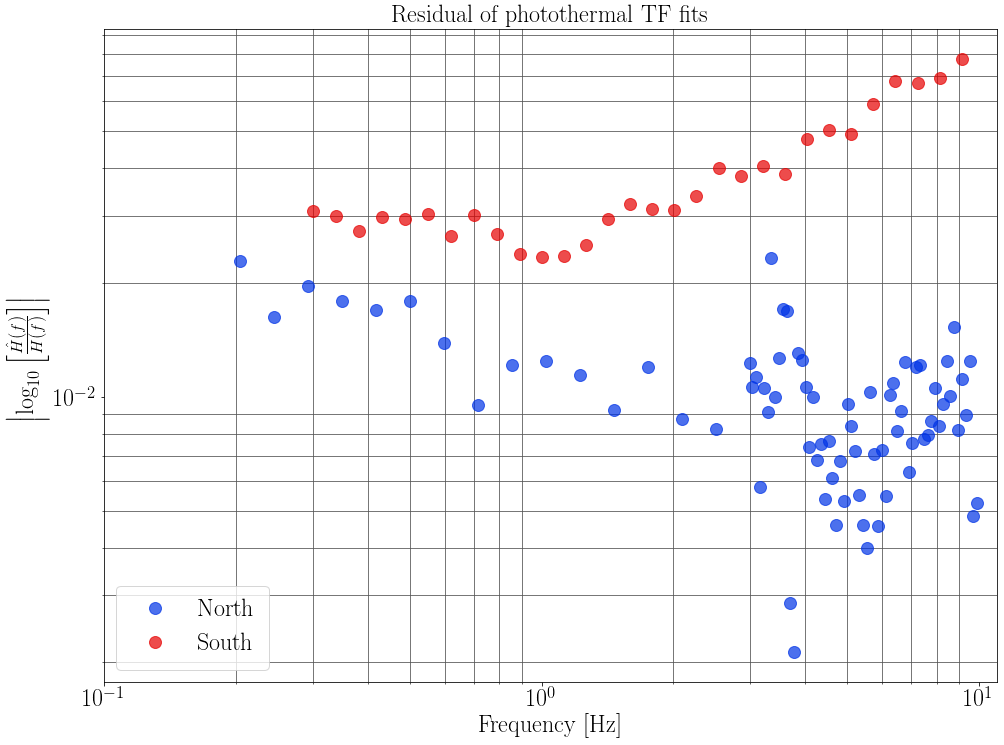

In [66]:
if isnotebook():
    plt.clf()
    plt.loglog(fMeasPTNorth[fMeasPTNorth<10],
               logLeast(qNorth[0][0], argsNorth[0], argsNorth[1]), 'o', c=cList[0], alpha=0.7,
              label='North')
    plt.loglog(fMeasPTSouth[fMeasPTSouth<10],
               logLeast(qSouth[0][0], argsSouth[0], argsSouth[1]), 'o', c=cList[1], alpha=0.7,
              label='South')
    plt.xlim(0.1, 11)
    plt.grid(which='both')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'$\left|\log_{10}\left[\frac{\hat{H}(f)}{H(f)}\right]\right|$')
    plt.title('Residual of photothermal TF fits')
    plt.legend(loc='lower left')

Uncertanties based on reduced $\chi^2$:

In [67]:
northUnc = np.sqrt((logLeast(qNorth[0][0], argsNorth[0], argsNorth[1])**2).sum()
                   /(len(argsNorth[0])-1)*qNorth[1][0,0])
southUnc = np.sqrt((logLeast(qSouth[0][0], argsSouth[0], argsSouth[1])**2).sum()
                   /(len(argsSouth[0])-1)*qSouth[1][0,0])
print('North statistical uncertainty: {0:.2g} ppm'.format(northUnc*1e6))
print('South statistical uncertainty: {0:.2g} ppm'.format(southUnc*1e6))

North statistical uncertainty: 0.032 ppm
South statistical uncertainty: 0.16 ppm


Uncertainties incorporating transmissivity uncertainties:

In [68]:
coatAbsNorth = uf(qNorth[0][0],northUnc)*uf(1, 7./153)
coatAbsSouth = uf(qSouth[0][0],southUnc)*uf(1, 7./153)
print('North per-mirror absorption: {:3uS} ppm'.format(coatAbsNorth*1e6 ))
print('South per-mirror absorption: {:3uS} ppm'.format(coatAbsSouth*1e6 ))

North per-mirror absorption: 5.14(24) ppm
South per-mirror absorption: 5.34(29) ppm


## Scatter estimates

In [51]:
mirrorTrans = uf(153,7)*1e-6
finesseNorth = uf(16700,1400)
finesseSouth = uf(17600,1600)
lossNorth = 2*np.pi/finesseNorth
lossSouth = 2*np.pi/finesseSouth
scatterNorth = lossNorth/2-mirrorTrans-coatAbsNorth
scatterSouth = lossSouth/2-mirrorTrans-coatAbsSouth
print('North cavity loss: {:3uS} ppm'.format(lossNorth*1e6))
print('South cavity loss: {:3uS} ppm'.format(lossSouth*1e6))
print('North per-mirror scatter: {:3uS} ppm'.format(scatterNorth*1e6))
print('South per-mirror scatter: {:3uS} ppm'.format(scatterSouth*1e6))

North cavity loss: 376(32) ppm
South cavity loss: 357(32) ppm
North per-mirror scatter: 30(17) ppm
South per-mirror scatter: 20(18) ppm


### Plot of photothermal TFs

In [56]:
_, PTtotQWLreal, PTtotQWLimag = np.loadtxt('PT_TF_QWL.txt', unpack=1)
PTtotQWL = PTtotQWLreal + 1j*PTtotQWLimag

OSError: PT_TF_QWL.txt not found.

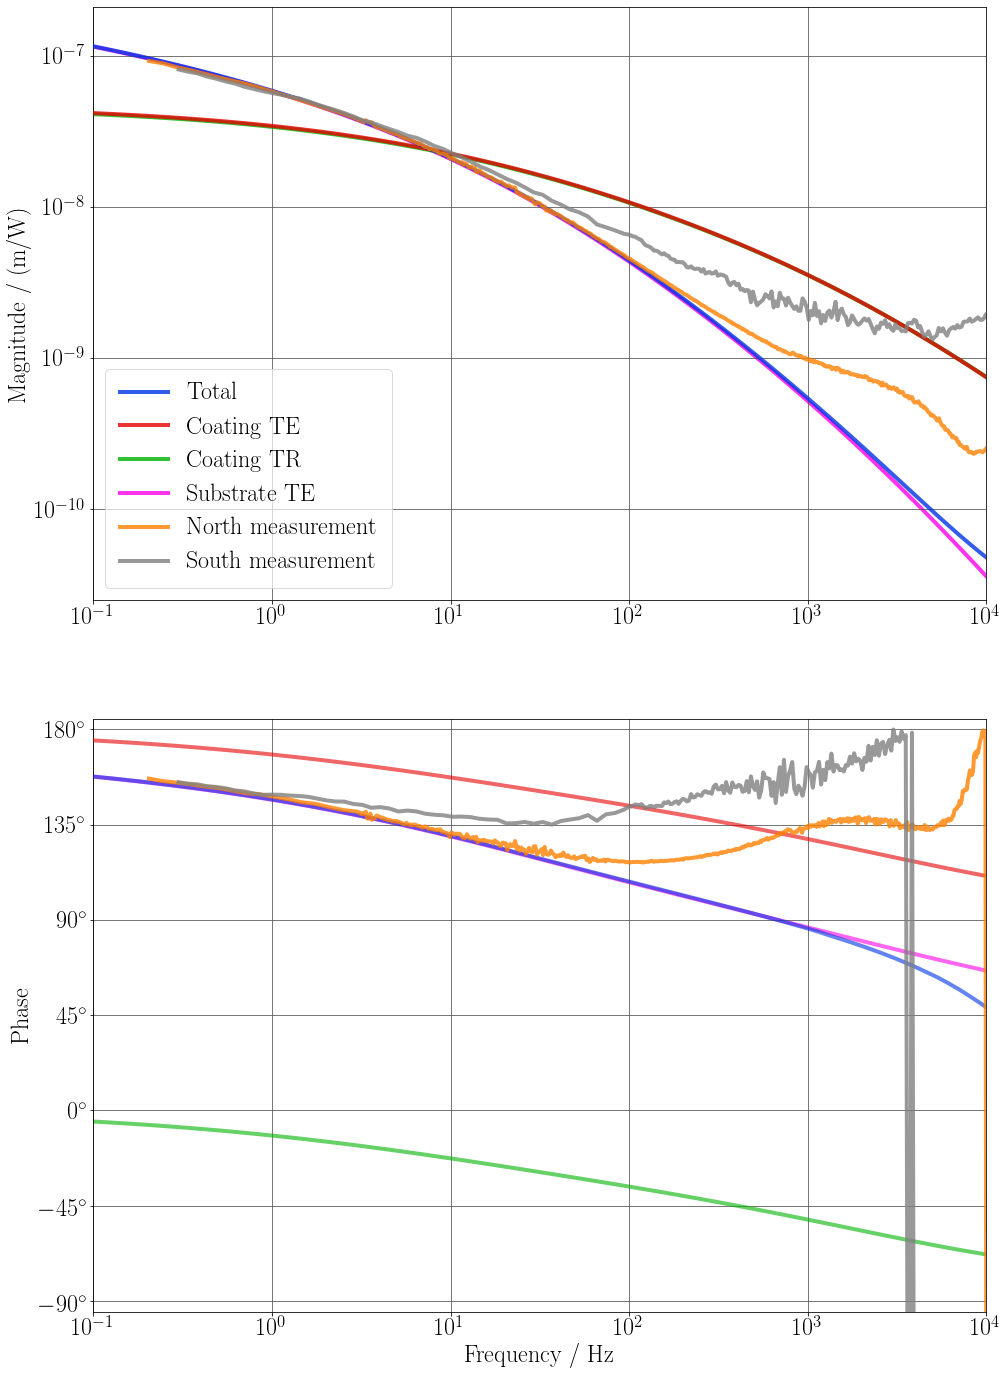

In [69]:
if isnotebook():
    PTList = [PTtotTF, PTCoatTF, PTtrTF, PTSubTF]#, PTtotQWL]
    PTLabels = ['Total', 'Coating TE', 'Coating TR', 'Substrate TE']#, 'QWL total']
    hPT = plt.figure(figsize=(16, 24))
    axMag = hPT.add_subplot(211)
    axPha = hPT.add_subplot(212, sharex=axMag)
    for ii, trace in enumerate(PTList):
        axMag.loglog(fShort, np.abs(trace),
                     c=cList[ii], label=PTLabels[ii], alpha=0.8, zorder=len(PTList)-ii)
        axPha.semilogx(fShort, np.angle(trace, deg=True),
                       c=cList[ii], alpha=0.6, zorder=len(PTList)-ii)
    axMag.loglog(fMeasPTNorth, np.abs(measPTNorth) / coatAbsNorth.nominal_value / (2*fConv.nominal_value), 
                 c=cList[6], label='North measurement', alpha=0.8, zorder=len(PTList)+1)
    axPha.semilogx(fMeasPTNorth, np.angle(measPTNorth, deg=True),
                   c=cList[6], alpha=0.8, zorder=len(PTList)+1)
    axMag.loglog(fMeasPTSouth, np.abs(measPTSouth) / coatAbsSouth.nominal_value / (2*fConv.nominal_value),
                 c=cList[7], label='South measurement', alpha=0.8, zorder=len(PTList)+2)
    axPha.semilogx(fMeasPTSouth, np.angle(measPTSouth, deg=True),
                   c=cList[7], alpha=0.8, zorder=len(PTList)+2)
    axMag.set_ylabel('Magnitude / (m/W)')
    #axMag.set_title(r'Photothermal TF for a two-mirror AlGaAs cavity')
    axMag.set_xlim(0.1, 1e4)
    axMag.set_ylim(2.5e-11, 2.1e-7)
    axMag.legend(loc='best', framealpha=0.7)
    axMag.grid(which='major', linestyle='solid')
    axPha.set_xlabel('Frequency / Hz')
    axPha.set_ylabel('Phase')
    phaticks = np.arange(-180, 181, 45)
    axPha.set_yticks(phaticks)
    axPha.set_yticks(np.arange(-180, 181, 15), minor=True)
    axPha.set_yticklabels(['${:.0f}^\circ$'.format(tick) for tick in phaticks])
    axPha.set_ylim(-95, 185)
    axMag.minorticks_off()
    axPha.minorticks_off()
    axPha.grid(which='major', linestyle='solid')

In [54]:
if isnotebook():
    hPT.tight_layout()
    hPT.savefig('PhotothermalTF.pdf')

## RIN

In [55]:
# Note: I'm using the south RIN measurement here twice
# Really we need separate north and south measurements
fNorthRIN, nomNorthRIN, stdNorthRIN = np.loadtxt('../Data/RINsouth.txt', unpack=1, usecols=(0, 1, 2))
fSouthRIN, nomSouthRIN, stdSouthRIN = np.loadtxt('../Data/RINsouth.txt', unpack=1, usecols=(0, 1, 2))
nomNorthRIN = np.interp(ff, fNorthRIN, nomNorthRIN)
stdNorthRIN = np.interp(ff, fNorthRIN, stdNorthRIN)
rinNorthPSD = unp.uarray(nomNorthRIN, stdNorthRIN)
nomSouthRIN = np.interp(ff, fSouthRIN, nomSouthRIN)
stdSouthRIN = np.interp(ff, fSouthRIN, stdSouthRIN)
rinSouthPSD = unp.uarray(nomSouthRIN, stdSouthRIN)
circPower = powInc * finesse / np.pi
absPower = coatAbs * circPower
ptNorthPSD = rinNorthPSD * absPower**2 * np.interp(ff, fShort, np.abs(PTtotTF)**2) * fConv**2
ptSouthPSD = rinSouthPSD * absPower**2 * np.interp(ff, fShort, np.abs(PTtotTF)**2) * fConv**2
ptPSD = ptNorthPSD + ptSouthPSD

## Seismic data

In [56]:
def mechTF(ff, f0, Q):
    return 1/(1+1j*ff/(f0*Q)-(ff/f0)**2)
seisData = scio.loadmat('../Data/psl_seis_2011_10_05.mat') # from a Guralp
seisFreq, seisVel = seisData['f_ver'][:,0], seisData['uf_ver'][:,2] # unfloated vertical velocity, m/(s * Hz**0.5)
seisAcc = np.interp(ff, seisFreq, seisVel * 2*np.pi*seisFreq)
fStack1 = 10.7 # Hz
QStack1 = 15
fStack2 = 35.4 # Hz
QStack2 = 8
fSpring = 5.2 # Hz
QSpring = 10
stackTF = mechTF(ff, fStack1, QStack1) * mechTF(ff, fStack2, QStack2)
springTF = mechTF(ff, fSpring, QSpring)
seisTF = stackTF*springTF
seisCouple = 6e-12 * cavLen # m / (m s**-2)
seismicPSD = (seisAcc * np.abs(seisTF))**2
seismicPSD = unp.uarray(seismicPSD, seismicPSD/50**0.5) * seisCouple**2

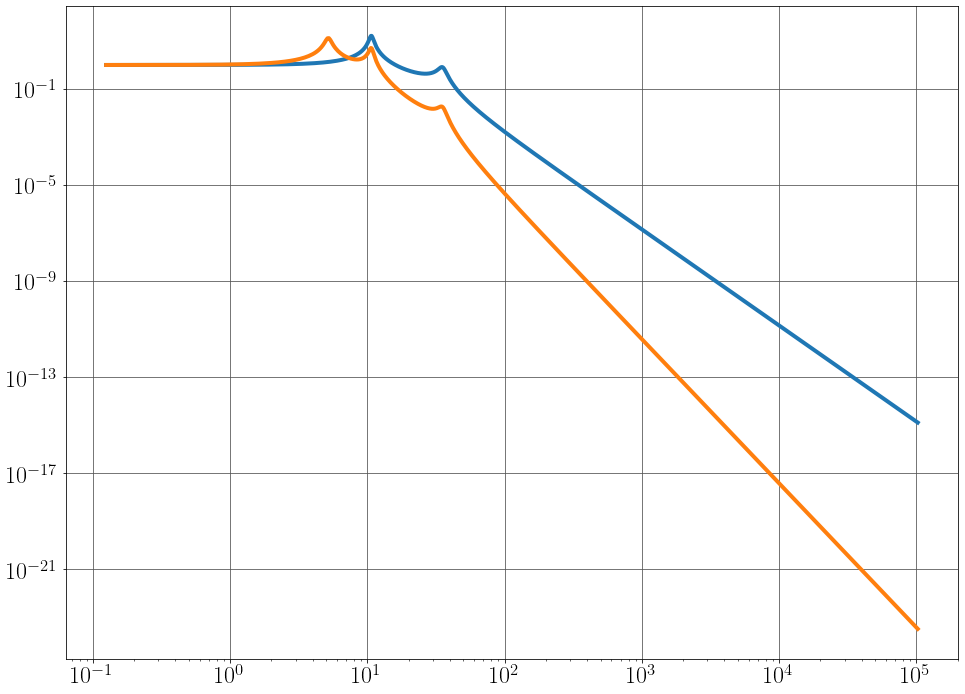

In [57]:
if isnotebook():
    plt.loglog(ff, np.abs(stackTF))
    plt.loglog(ff, np.abs(seisTF))

# PLL noise

In [58]:
#pllFreq, pllASD = np.loadtxt('../Data/PLL_1kHz_Rb.txt', unpack=1)
#pllOscPSD = np.interp(ff, pllFreq, pllASD**2)
#pllOscPSD = unp.uarray(pllOscPSD, pllOscPSD/50**0.5)
# Magic number from Tara's old noise budget; somehow connected to elog 2012-02-09
pllReadPSD = (ff*0.0207*5.04e-5)**2
pllOscFreq, pllOscASD = np.loadtxt('../Data/PLLOscNoise_1kHz.txt', unpack=1)
pllOscPSD = np.interp(ff, pllOscFreq, pllOscASD**2)
pllOscPSD = unp.uarray(pllOscPSD, pllOscPSD/50**0.5)

pllReadPSD = unp.uarray(pllReadPSD, pllReadPSD/50**0.5)

# Adding Sept 2, 2017 Measurement
This measurement is tenuous at best, but I'm adding it anyway

In [59]:
# New git repo, visit here: 
# https://git.ligo.org/andrew-wade/ctn_labdata
# If you have git.ligo.org permissions, run:
# git clone git@git.ligo.org:andrew-wade/ctn_labdata.git

gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20170902_CalibratedBeatnoteSpectrum/')
filename = '20170902_005925_CalibratedSpectrum.txt'
txtData = np.loadtxt(gitDir + filename)

sept2017Freq = txtData[:,0]
sept2017ASD = txtData[:,1]

OSError: C:\Users\ancha/Git/cit_ctnlab/ctn_labdata/data/20170902_CalibratedBeatnoteSpectrum/20170902_005925_CalibratedSpectrum.txt not found.

#  Adding Nov 02, 2017 Measurement
Two months later, but what has changed?

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20171102_CalibratedBeatnoteSpectrum/')
filename = '20171102_155758_CalibratedSpectrum.txt'
txtData = np.loadtxt(gitDir + filename)

nov02_2017Freq = txtData[:,0]
nov02_2017ASD = txtData[:,1]

# Adding Nov 13, 2017 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20171113_CalibratedBeatnoteSpectrum/')
filename = '20171113_150703_CalibratedSpectrum.txt'
txtData = np.loadtxt(gitDir + filename)

nov13_2017Freq = txtData[:,0]
nov13_2017ASD = txtData[:,1]

# Adding Dec 12, 2017 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20171211_CalibratedBeatnoteSpectrum/')
filename = 'SplicedFromErrorandControlSignal_CalibratedBeatnoteSpectrum_20171212_000405.txt'
txtData = np.loadtxt(gitDir + filename)

dec12_2017Freq = txtData[:,0]
dec12_2017ASD = txtData[:,1]

# Adding Dec 13, 2017 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20171213_CalibratedBeatnoteSpectrum/')
filename = 'SplicedFromErrorandControlSignal_CalibratedBeatnoteSpectrum_20171213_135310.txt'
txtData = np.loadtxt(gitDir + filename)

dec13_2017Freq = txtData[:,0]
dec13_2017ASD = txtData[:,1]

# Adding Feb 07, 2018 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20180207_TransBeatnoteSpectrum/')
filename = 'StitchedSpectrum_PLLControlSignal_SR560Gain_20_MarconiFMDevn_10kHz_SR785Attenuation_4dBVpk_Avg_20_Span_102p4kHz_07-02-2018_173644.txt'
txtData = np.loadtxt(gitDir + filename)

feb07_2018Freq = txtData[:,0]
feb07_2018ASD = txtData[:,1]

# Adding Jan 03, 2019 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20190103_BeatNoteSpectrum_Wideband_Detector/')
filename = 'Jan03_2019_BNnoise__MedianData.txt'
txtData = np.loadtxt(gitDir + filename)

jan03_2019Freq = txtData[:,0]
jan03_2019ASD = txtData[:,1]

# Adding Jan 15, 2019 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20190115_RIN_TF_AND_BN/')
filename = 'Jan15_2019_BN_noise__MedianData.txt'
txtData = np.loadtxt(gitDir + filename)

jan15_2019Freq = txtData[:,0]
jan15_2019ASD = txtData[:,1]

# Adding Jan 24, 2019 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20190124_BeatNote/')
filename = 'BeatNoteJan24_2019_MedianData.txt'
txtData = np.loadtxt(gitDir + filename)

jan24_2019Freq = txtData[:,0]
jan24_2019ASD = txtData[:,1]

# Adding Jan 25, 2019 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20190125_BeatNote_ResBNPD/')
filename = 'BeatNoteJan25_2019_MedianData.txt'
txtData = np.loadtxt(gitDir + filename)

jan25_2019Freq = txtData[:,0]
jan25_2019ASD = txtData[:,1]

In [ ]:
# Adding Jun 03, 2019 Measurement

In [ ]:
gitDir = os.path.expanduser('~/Git/cit_ctnlab/ctn_labdata/data/20190603_BeatNoteMeas/')
filename = 'BNmeas_2019_06_03.txt'
txtData = np.loadtxt(gitDir + filename)

jun03_2019Freq = txtData[:,0]
jun03_2019ASD = txtData[:,1]

In [ ]:
newFreqList = [nov13_2017Freq,
               dec13_2017Freq,
               jan03_2019Freq,
               jan15_2019Freq,
               jan24_2019Freq,
               jan25_2019Freq,
               jun03_2019Freq]
newTraceList = [nov13_2017ASD,
                dec13_2017ASD,
                jan03_2019ASD,
                jan15_2019ASD,
                jan24_2019ASD,
                jan25_2019ASD,
                jun03_2019ASD]
newLabelList = ['Nov 13 2017 Beat',
                'Dec 13 2017 Beat',
                'Jan 03 2019 Beat',
                'Jan 15 2019 Beat',
                'Jan 24 2019 Beat',
                'Jan 25 2019 Beat',
                'Jun 03 2019 Beat']
newColorList = ['#FFC300',
                '#3CB371',
                '#338AFF',
                '#FF00FF',
                '#9400D3',
                '#ff0000',
                '#000000']

# Plotting

In [60]:
traceList = [beatPSD,
             4 * coatBrownianPSD * fConv**2,
             4 * coatThermoOpticPSD * fConv**2,
             4 * subBrownianPSD * fConv**2,
             4 * subThermoelasticPSD * fConv**2,
             2 * pdhShotPSD,
             pllOscPSD,
             pllReadPSD,
             seismicPSD * fConv**2,
             ptPSD,
             residFreqPSD]
totalPSD = np.sum(traceList[1:], axis=0)

traceList = [totalPSD] + traceList
labelList = [r'Total Expected',
             r'Old Beat Meas',
             r'Coating Brownian',
             r'Coating TO',
             r'Substrate Brownian',
             r'Substrate TE',
             r'PDH shot noise',
             r'PLL osc. noise, 1 kHz/V',
             r'PLL readout, A*S=200kHz/V',
             r'Seismic coupling',
             r'Photothermal noise, ISS on',
             r'Residual NPRO noise']

In [ ]:
hNB = plt.figure(figsize=(16, 12))
ax = hNB.add_subplot(111)
# ax.loglog(sept2017Freq, sept2017ASD, label='Sept 02 2017 Beat', alpha=0.8, c=cList[-1], lw=1.5)
for ii, newTrace in enumerate(newTraceList):
    newFreq = newFreqList[ii]
    newColor = newColorList[ii]
    newLabel = newLabelList[ii]
    ax.loglog(newFreq, newTrace, label=newLabel, alpha=0.8, c=newColor, lw=1.5)
    
# ax.fill_between(ff, np.sqrt(np.max([unp.nominal_values(totalPSD) - unp.std_devs(totalPSD), np.ones(len(totalPSD))*1e-12], axis=0)),
#                     np.sqrt(unp.nominal_values(totalPSD) + unp.std_devs(totalPSD)),
#                     alpha=0.2, color=cList[-1], lw=0)
for ii, trace in enumerate(traceList):
    ax.loglog(ff, unp.nominal_values(unp.sqrt(trace)),
              label=labelList[ii], c=cList[ii], lw=1.5, alpha=0.8)
    ax.fill_between(ff, np.sqrt(np.max([unp.nominal_values(trace) - unp.std_devs(trace), np.ones(len(trace))*1e-12], axis=0)),
                    np.sqrt(unp.nominal_values(trace) + unp.std_devs(trace)),
                    alpha=0.2, color=cList[ii], lw=0)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'\textsc{asd} of beat note frequency $\bigl[\textsc{Hz/Hz}^{1/2}\bigr]$')
ax.legend(loc='best', fontsize=18, numpoints=2, borderpad=0.1, ncol=3, columnspacing=0.5, framealpha=0.7)
ax.grid(linestyle='solid', which='major', alpha=0.75)
ax.grid(linestyle='dashed', which='minor', alpha=0.25)
ax.set_xlim(0.32, 12e3)
ylimits = [6e-5, 7e3]
ax.set_ylim(ylimits[0], ylimits[1])
ax.set_title(r'Noise budget for two 3.68-cm cavities '
             r'with GaAs/Al$_{0.92}$Ga$_{0.08}$As Bragg mirrors')


In [61]:
cwd = os.getcwd()
os.chdir('./OldEstimates')
for ii, trace in enumerate(traceList):
    ASD = unp.nominal_values(unp.sqrt(trace))
    ASDunc = unp.std_devs(unp.sqrt(trace))
    dataToWrite = np.transpose(np.array([ff,ASD,ASDunc]))
    header='\n'.join([labelList[ii], "Freq[Hz]    ASD[Hz/rtHz]    ASD Uncertainity[Hz/rtHz]"])
    filename = 'OldEst_'+labelList[ii]+'.txt'
    filename = filename.replace('*','x')
    filename = filename.replace('/','p')
    filename = filename.replace(',','')
    np.savetxt(filename,dataToWrite,header=header)
os.chdir(cwd)

In [ ]:
hNB.savefig('../Plots/' + time.strftime("%Y%m%d_%H%M%S") + 'noiseBudget.pdf', facecolor=hNB.get_facecolor())

In [ ]:
traceList2 = [beatPSD, totalPSD] + [trace for trace in traceList[1:]]
traceList2 = [ff] + [np.sqrt(unp.nominal_values(trace)) for trace in traceList2]
np.savetxt('AlGaAsNoiseBudgetAndData.txt', np.transpose([traceList2]))

# Make Bokeh

In [ ]:
if makebokeh:
    import pandas as pd
    from bokeh.plotting import figure, output_file, output_notebook, show
    from bokeh.models import ColumnDataSource, HoverTool, CrosshairTool, PrintfTickFormatter
    from bokeh.palettes import Set3
    from bokeh.layouts import column
    from bokeh.models import Range1d

In [ ]:
if makebokeh:
    plotFile = '../HTML/'+time.strftime("%Y%m%d_%H%M%S") +'_CTN_NoiseBudget.html'
#     output_file(plotFile)

    TOOLS = 'save, crosshair, pan, box_zoom, wheel_zoom, reset'
    p1 = figure(tools=TOOLS, width=1400, height=820, x_axis_type='log', y_axis_type='log', background_fill_color="black")

    crosshair = p1.select(type=CrosshairTool)
    crosshair.line_color = 'white'

    p1.title.text = 'CTN Lab NoiseBudget - ' + time.strftime("%b-%d-%Y %H:%M:%S")
    p1.xaxis.axis_label = 'Frequency [ Hz ]'
    p1.yaxis.axis_label = 'ASD [ Hz / rtHz ]'
    p1.x_range = Range1d(min(ff), max(ff))
    p1.y_range = Range1d(ylimits[0], ylimits[1])
    p1.xaxis.axis_label_text_font_size = "18pt"
    p1.yaxis.axis_label_text_font_size = "18pt"
    p1.xaxis.axis_label_text_color = 'white'
    p1.yaxis.axis_label_text_color = 'white'
    p1.xaxis.axis_line_color = 'white'
    p1.yaxis.axis_line_color = 'white'
    p1.xgrid.grid_line_color = 'grey'
    p1.ygrid.grid_line_color = 'grey'
    p1.xaxis.major_label_text_color = 'white'
    p1.yaxis.major_label_text_color = 'white'
    p1.xaxis.minor_tick_line_color = 'grey'
    p1.yaxis.minor_tick_line_color = 'grey'
    p1.xaxis.major_label_text_font_size = '14pt'
    p1.yaxis.major_label_text_font_size = '14pt'
    p1.xaxis[0].formatter = PrintfTickFormatter(format="%f")
    p1.yaxis[0].formatter = PrintfTickFormatter(format="%f")

    p1.border_fill_color = 'black'
    p1.title.text_font_size = "24pt"
    p1.title.text_color = 'white'


    hh = np.array([])
    for trace, label, color in zip(traceList, labelList, Set3[len(traceList)]):
        data = unp.nominal_values(unp.sqrt(trace))

        h0 = p1.line(ff, data, line_width=2, alpha=0.75, hover_alpha=0.9, color=color, hover_color=color, legend=label)
        h0.data_source.add(np.array([label] * len(ff)), name="name")
        hh = np.append(h0, hh)
    
    for ii, newTrace in enumerate(newTraceList):
        newFreq = newFreqList[ii]
        newColor = newColorList[ii]
        newLabel = newLabelList[ii]
        h1 = p1.line(newFreq, newTrace, line_width=2, alpha=0.75, hover_alpha=0.9, \
                     color=newColor, hover_color=newColor, legend=newLabel, name=newLabel)
        h1.data_source.add(np.array([newLabel] * len(newFreq)), name="name")
        hh = np.append(h1, hh)
    
    p1.add_tools( 
        HoverTool(tooltips=[("name", "@name"),
                            ('(x,y)','@x Hz, @y Hz/rtHz'),], renderers=hh.tolist() ) )
    # p1.add_tools(CrosshairTool(tooltips=['fill_color', 'white']))

    p1.legend.location = "top_right"
    p1.legend.click_policy="hide"
    p1.legend.background_fill_color = 'grey'
    p1.legend.label_text_color = 'white'
    p1.legend.background_fill_alpha = 0.5

#     show(p1)  # Do not use, you don't have any control over the final HTML output.  Below two cells gives you control.

In [ ]:
# print h1.data_source.name
# print h1.data_source.column_names
# print h1.data_source

In [ ]:
if makebokeh:
    from jinja2 import Template
    from bokeh.embed import file_html
    from bokeh.models import Div, Paragraph
    from bokeh.resources import CDN
    from bokeh.util.browser import view

In [ ]:
if makebokeh:
    # write some HTML directly using some bokeh.embed functionality
    template = Template("""
    <!DOCTYPE html>
    <html lang="en">
        <head>
            <meta charset="utf-8">
            <title>{{ title if title else "Bokeh Plot" }}</title>
            {{ bokeh_css }}
            {{ bokeh_js }}
            <style>
                html {
                    width: 100%;
                    height: 100%;
                }
                body {
                    width: 100%;
                    height: 100%;
                    margin: 0;
                    background-color: black;
                }
            </style>
        </head>
        <body>
            {{ plot_div|indent(8) }}
            {{ plot_script|indent(8) }}
        </body>
    </html>
    """)

    html = file_html(p1, template=template, resources=CDN)

    output_file = plotFile

    with open(output_file, 'w') as f:
        f.write(html)

    view(output_file)

In [ ]:
if makebokeh:
    # check if Craig's lappy.  If true, also save the plot in personal github page and git commit it automatically
    homeDir = os.path.expanduser('~')
    if homeDir == '/Users/ccahilla':
        # Make two new plot files
        plotFile1 = os.path.expanduser('~/Git/ccahilla.github.io/oldNoisebudgets/'
                                      +time.strftime("%Y%m%d_%H%M%S") +'_CTN_NoiseBudget.html')
        plotFile2 = os.path.expanduser('~/Git/ccahilla.github.io/noise.html')
        
        output_file = plotFile1
        with open(output_file, 'w') as f:
            f.write(html)
        output_file = plotFile2
        with open(output_file, 'w') as f:
            f.write(html)
        
        # Configure and run the git commit automatically
        gitCommand = 'git --git-dir ~/Git/ccahilla.github.io/.git/ --work-tree ~/Git/ccahilla.github.io/'
        gitCommitMessage = time.strftime("%B %d, %Y  %H:%M:%S") + ' - Coatings Thermal Noise Lab Noisebudget'
        
        # Use && on the command line to run multiple commands in a row
        autoGitCommitCommand = gitCommand + ' add noise.html && '\
            + gitCommand + ' add oldNoisebudgets/* && '\
            + gitCommand + ' commit -m "' + gitCommitMessage + '" && '\
            + gitCommand + ' push'
        
        os.system(autoGitCommitCommand)

In [ ]:
# List all the packages on your local environment
import pip #needed to use the pip functions
for i in pip.get_installed_distributions(local_only=True):
    print(i)

# References
Summary of references used in this notebook

[Author List, Title, Journal, Vol, Issue (date)](http://internet.net)